In [1]:
import sys
sys.path.append("../../")

from dataset_large import get_halo_dataset
from tqdm import tqdm
import numpy as np

# Make sure tf does not hog all the GPU memory
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

%load_ext autoreload
%autoreload 2

2024-05-28 06:22:40.115834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 06:22:48.165096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
batch_size = 64
num_samples = 5_000

#tfrecords_path = '/pscratch/sd/c/cuesta/quijote_tfrecords'
tfrecords_path = '/pscratch/sd/c/cuesta/equivariance/bsq'
dataset, num_total, mean, std, mean_params, std_params = get_halo_dataset(batch_size=batch_size,  # Batch size
                           num_samples=num_samples,  # If not None, will only take a subset of the dataset
                           split='train',  # 'train', 'val'
                           standardize=True,  # If True, will standardize the features
                           return_mean_std=True,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                           seed=42,  # Random seed
                           features=features,  # Features to include
                           params=params,  # Parameters to include
                           tfrecords_path = tfrecords_path,
                        )
std = np.array(std)
# Print number of samples
print(f"Number of samples: {num_total}")

Number of samples: 5000


In [5]:
iterator = iter(dataset)

x_train, params_train = [], []
for _ in tqdm(range(num_total // batch_size)):
    x, params = next(iterator)
    x_train.append(np.array(x))
    params_train.append(np.array(params))

x_train = np.concatenate(x_train, axis=0)
params_train = np.concatenate(params_train, axis=0)

100%|██████████| 78/78 [00:02<00:00, 34.06it/s]


In [6]:
x_train.shape

(4936, 5000, 3)

In [7]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [8]:
from models.utils.equivariant_graph_utils import get_equivariant_graph
from models.utils.graph_utils import build_graph, compute_distances, nearest_neighbors
from models.segnn import SEGNN
from models.gnn import GNN
from models.utils.graph_utils import get_apply_pbc

In [9]:
import e3nn_jax as e3nn
from typing import Dict
import jax
from models.gnn import GNN
from models.segnn import SEGNN
from models.egnn import EGNN
from models.nequip import NequIP

use_pbcs = True
apply_pbc = get_apply_pbc(std=std / 1000.,) if use_pbcs else None
k = 10
n_radial = 64
position_features = True
r_max = 0.6
use_3d_distances = False
l_max = 1
# TODO: sphharm norm parity between SEGNN and NequIP

SEGNN_PARAMS = {
    "d_hidden": 128,
    "l_max_hidden": l_max,
    "n_layers": 3,
    "message_passing_steps": 3,
    "task": "graph",
    "output_irreps": e3nn.Irreps("1x0e"),
    "hidden_irreps": None,
    "message_passing_agg": "mean",
    "readout_agg": "mean",
    "n_outputs": 2,
    "scalar_activation": "gelu",
    "gate_activation": "sigmoid",
    "mlp_readout_widths": (4, 2, 2),
    "residual": False,
}

GNN_PARAMS = {
    "d_hidden": 256,
    "message_passing_steps": 5,
    "n_layers": 6,
    "activation": "gelu",
    "message_passing_agg": "mean",
    "readout_agg": "attn",
    "mlp_readout_widths": (4, 2, 2),
    "task": "graph",
    "n_outputs": 2,
    "norm": "none",
    "position_features": position_features,
    "residual": True,
}


class GraphWrapper(nn.Module):
    param_dict: Dict

    @nn.compact
    def __call__(self, x):

        positions = e3nn.IrrepsArray("1o", x.nodes[..., :3])
        
        if x.nodes.shape[-1] == 3:
            nodes = e3nn.IrrepsArray("1o", x.nodes[..., :])
            velocities = None
        else:
            nodes = e3nn.IrrepsArray("1o + 1o", x.nodes[..., :])
            velocities = e3nn.IrrepsArray("1o", x.nodes[..., 3:6])

        
        st_graph = get_equivariant_graph(
            node_features=nodes,
            positions=positions,
            velocities=None,
            steerable_velocities=False,
            senders=x.senders,
            receivers=x.receivers,
            n_node=x.n_node,
            n_edge=x.n_edge,
            globals=x.globals,
            edges=None,
            lmax_attributes=l_max,
            apply_pbc=apply_pbc,
            n_radial_basis=n_radial,
            r_max=r_max,
        )
        
        return jax.vmap(SEGNN(**self.param_dict))(st_graph)
    
class GraphWrapperGNN(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        return jax.vmap(GNN(**self.param_dict))(x)
    
class GraphWrapperEGNN(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        return jax.vmap(EGNN(positions_only=True, n_outputs=2, n_layers=4, apply_pbc=apply_pbc, n_radial_basis=n_radial, r_max=r_max, tanh_out=True))(x)
    
import jraph
import jax.numpy as jnp

class GraphWrapperNequIP(nn.Module):
    param_dict: Dict
    @nn.compact
    def __call__(self, x):
        if x.nodes.shape[-1] == 3:
            ones = jnp.ones(x.nodes[..., :].shape[:2] + (1,))
            nodes = jnp.concatenate([x.nodes[..., :], x.nodes[..., :], ones], axis=-1)
            nodes = e3nn.IrrepsArray("1o + 1o + 1x0e", nodes)
        else:
            nodes = e3nn.IrrepsArray("1o + 1o + 1x0e", x.nodes[..., :])
        
        graph = jraph.GraphsTuple(
            n_node=x.n_node,
            n_edge=x.n_edge,
            edges=None,
            globals=x.globals,
            nodes=nodes, 
            senders=x.senders,
            receivers=x.receivers)
        
        return jax.vmap(NequIP(n_outputs=2, n_radial_basis=n_radial, r_cutoff=r_max, sphharm_norm='component'))(graph)

In [10]:
graph = build_graph(x_train[:2], 
                None, 
                k=k, 
                apply_pbc=apply_pbc,
                use_edges=True, 
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
)



In [11]:

model = GraphWrapper(SEGNN_PARAMS, )

out, params = model.init_with_output(jax.random.PRNGKey(0), graph)

# Number of parameters
print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")

out

Number of parameters: 573253


/tmp/ipykernel_1861364/2878200261.py:6: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  print(f"Number of parameters: {sum([p.size for p in jax.tree_leaves(params)])}")


Array([[-0.0047297 , -0.00014558],
       [-0.00442586, -0.00014991]], dtype=float32)

In [12]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [13]:
# Define train state and replicate across devices

# Cosine learning rate schedule
lr = optax.cosine_decay_schedule(3e-4, 2000)
tx = optax.adamw(learning_rate=lr, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [14]:
def loss_mse(pred_batch, cosmo_batch,):
    return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    halo_graph = build_graph(halo_batch, 
                None, 
                k=k, 
                use_edges=True, 
                apply_pbc=apply_pbc,
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
    )
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [15]:
n_steps = 2000
n_batch = 32

key = jax.random.PRNGKey(0)

losses = []
with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x_train.shape[0], shape=(n_batch,))
        
        halo_batch, cosmo_batch = x_train[idx], params_train[idx]

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        train_loss = unreplicate(metrics["loss"])
        steps.set_postfix(loss=train_loss)
        losses.append(train_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1861364/2505061870.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_1861364/2505061870.py:16: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
  0%|          | 1/2000 [00:14<8:17:13, 14.92s/it, loss=0.9593386]/tmp/ipykernel_1861364/2505061870.py:15: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
/tmp/ipykernel_1861364/2505061870.py:16: DeprecationWarning: jax.tree_map is deprecated: use jax.tre

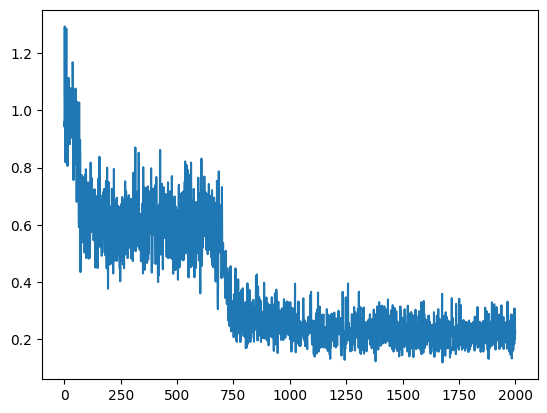

In [16]:
plt.plot(losses)

100%|██████████| 3/3 [00:12<00:00,  4.22s/it]

Mean MSE: 0.19039244949817657


Text(0, 0.5, 'Predicted')

<Figure size 1200x600 with 0 Axes>

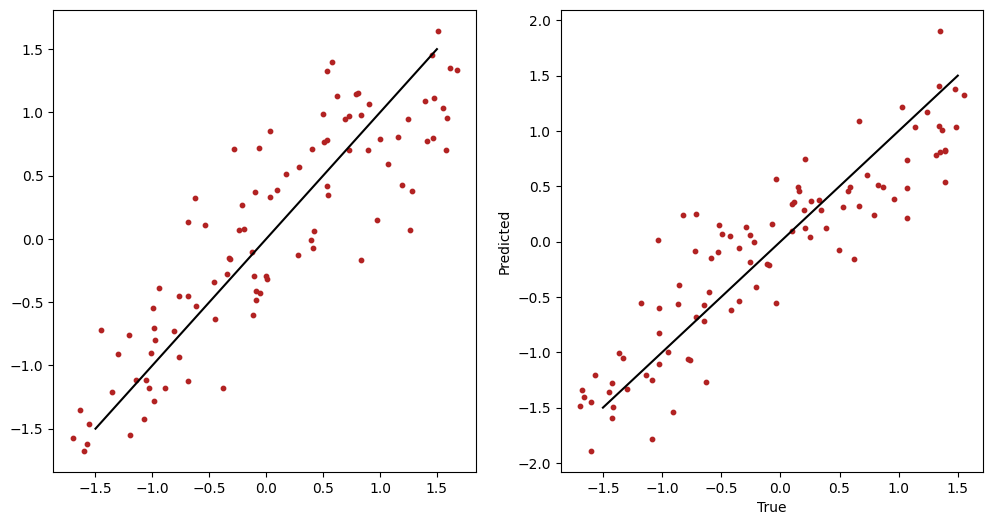

In [17]:

features = ['x', 'y', 'z']  # ['x', 'y', 'z', 'Jx', 'Jy', 'Jz', 'vx', 'vy', 'vz', 'M200c']
params = ['Omega_m', 'sigma_8']  # ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']

dataset, num_total = get_halo_dataset(
    batch_size=32,  # Batch size
                        num_samples=250,  # If not None, will only take a subset of the dataset
                        split='val',  # 'train', 'val'
                        standardize=True,  # If True, will standardize the features
                        return_mean_std=False,  # If True, will return (dataset, num_total, mean, std, mean_params, std_params), else (dataset, num_total)
                        seed=42,  # Random seed
                        features=features,  # Features to include
                        params=params, # Parameters to include
                        tfrecords_path = tfrecords_path, #'/pscratch/sd/c/cuesta/quijote_tfrecords',
                        )

iterator = iter(dataset)

plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

mse_list = []

x_val, params_val = [], []
for _ in tqdm(range(num_total // batch_size)):
    x, params = next(iterator)

    # Convert to numpy
    x, params = np.array(x), np.array(params)
    
    # x_val.append(np.array(x))
    # params_val.append(np.array(params))

    graph = build_graph(x, 
                None, 
                k=k, 
                use_edges=True, 
                apply_pbc=apply_pbc,
                n_radial_basis=n_radial,
                r_max=r_max,
                use_3d_distances=use_3d_distances,
                )

    pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    ax[0].scatter(params[:, 0], pred[:, 0], s=10, color='firebrick')
    ax[1].scatter(params[:, 1], pred[:, 1], s=10, color='firebrick')

    mse = np.mean((pred - params) ** 2)
    mse_list.append(mse)

# Diagonal
ax[0].plot([-1.5, 1.5], [-1.5, 1.5], color='black')
ax[1].plot([-1.5, 1.5], [-1.5, 1.5], color='black')

print(f"Mean MSE: {np.mean(mse_list)}")

# # # Diagonal line
# plt.plot([0, 0.5], [0, 0.5])

plt.xlabel("True")
plt.ylabel("Predicted")